# Introduction 

----

**Objectives** :  Notebook ini berisi proses Exploratory Data Analysis (EDA), text preprocessing, pembuatan model rekomendasi berbasis TF-IDF, serta evaluasi hasil rekomendasi. Pendekatan yang digunakan adalah content-based filtering dengan memanfaatkan teks ulasan pengguna.

----

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP & Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Utilitas
import joblib
import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Ziko Ananda
[nltk_data]     Setyawan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Ziko Ananda
[nltk_data]     Setyawan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Loading

Pada project ini digunakan dua dataset:
- `data_cleaned.csv` → data produk headset (product-level)
- `review_data_cleaned.csv` → data ulasan pengguna (review-level)

In [2]:
df_product = pd.read_csv("./scrape_and_cleaning/data_cleaned.csv")
df_review = pd.read_csv("./scrape_and_cleaning/review_data_cleaned.csv")

print(df_product.shape)
print(df_review.shape)

(287, 11)
(1542, 4)


In [3]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1542 entries, 0 to 1541
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product        1542 non-null   object
 1   brand          1542 non-null   object
 2   review_text    1526 non-null   object
 3   review_rating  1542 non-null   object
dtypes: object(4)
memory usage: 48.3+ KB


In [4]:
"""
Menghapus duplikasi ulasan untuk mencegah bias teks
akibat review yang ter-scrape berulang.
"""

print("Jumlah duplikasi sebelum:", df_review.duplicated().sum())

df_review = df_review.drop_duplicates(
    subset=["product", "review_text"]
)

print("Jumlah duplikasi setelah:", df_review.duplicated().sum())

Jumlah duplikasi sebelum: 534
Jumlah duplikasi setelah: 0


In [5]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1008 entries, 0 to 1541
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product        1008 non-null   object
 1   brand          1008 non-null   object
 2   review_text    999 non-null    object
 3   review_rating  1008 non-null   object
dtypes: object(4)
memory usage: 39.4+ KB


In [6]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product        287 non-null    object 
 1   feature        287 non-null    object 
 2   brand          287 non-null    object 
 3   price          287 non-null    float64
 4   rating         287 non-null    float64
 5   color          287 non-null    object 
 6   ear_placement  287 non-null    object 
 7   form_factor    287 non-null    object 
 8   impedance      287 non-null    object 
 9   image_url      287 non-null    object 
 10  reviews        287 non-null    object 
dtypes: float64(2), object(9)
memory usage: 24.8+ KB


In [7]:
df_product.duplicated().sum()

0

# Exploratory Data Analysis

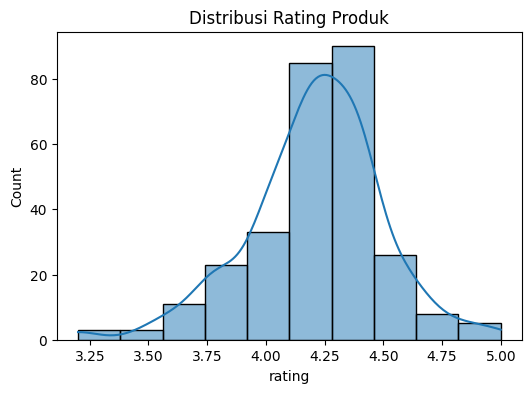

In [8]:
# Distribusi Rating Produk
plt.figure(figsize=(6,4))
sns.histplot(df_product['rating'], bins=10, kde=True)
plt.title("Distribusi Rating Produk")
plt.show()

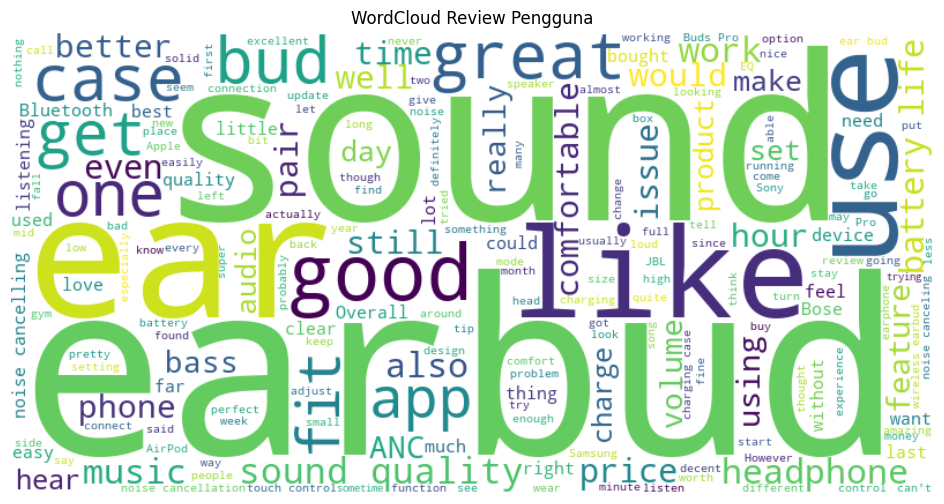

In [9]:
# WordCloud
text_all = " ".join(df_review['review_text'].dropna().astype(str))

wc = WordCloud(
width=800,
height=400,
background_color='white',
stopwords=set(stopwords.words('english'))
).generate(text_all)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud Review Pengguna")
plt.show()

# Text Preprocessing

In [10]:
stop_words = set(stopwords.words("english"))


def clean_text(text):
    """
    Membersihkan teks ulasan:
    - lowercase
    - hapus karakter non-huruf
    - menghapus whitespaces
    - tokenisasi
    - stopword removal
    """
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = text.strip()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return " ".join(tokens)


# Terapkan preprocessing
df_review['clean_review'] = df_review['review_text'].apply(clean_text)

# Modeling

TF-IDF Vectorization (Review-Level)

TF-IDF diterapkan pada teks ulasan individual, bukan pada level produk. Pendekatan ini memungkinkan sistem memilih produk berdasarkan review yang paling relevan.

In [11]:
tfidf = TfidfVectorizer(max_features=5000,
                        ngram_range=(1,2),
                        min_df=2)

tfidf_review_matrix = tfidf.fit_transform(df_review['clean_review'])
print(tfidf_review_matrix.shape)

(1008, 5000)


In [12]:
def compute_review_similarity(keyword):
    """
    Menghitung cosine similarity antara keyword pengguna
    dan seluruh review individual.
    """
    query_clean = clean_text(keyword)
    query_vector = tfidf.transform([query_clean])

    similarity_scores = cosine_similarity(
        query_vector, tfidf_review_matrix).flatten()

    df_sim = df_review.copy()
    df_sim['similarity'] = similarity_scores
    return df_sim.sort_values('similarity', ascending=False)

In [13]:
def recommend_products(keyword, top_n=3):
    """
    Menghasilkan Top-N produk headset berdasarkan
    review dengan similarity tertinggi.
    """
    df_sim = compute_review_similarity(keyword)

    top_reviews = (
        df_sim
        .drop_duplicates(subset='product', keep='first')
        .head(top_n)
    )

    return top_reviews

In [14]:
def format_recommendation(top_reviews):
    """
    Mengubah hasil rekomendasi menjadi
    teks naratif yang mudah dibaca.
    """
    lines = []
    lines.append("Top 3 Produk Headset Berdasarkan Review:\n")

    for idx, row in enumerate(top_reviews.itertuples(), start=1):
        lines.append(
            f"{idx}. Product: {row.product}\n"
            f" Brand: {row.brand}\n"
            f" Rating Review: {row.review_rating}\n"
            f" Cuplikan Review:\n"
            f" \"{row.review_text[:300]}\"\n"
            f" Similarity Score: {row.similarity:.4f}\n"
            )

    return "\n".join(lines)

In [15]:
# Model Inference
top_reviews = recommend_products(
    keyword="great battery life for outdoor gaming",
    top_n=3
    )

print(format_recommendation(top_reviews))

Top 3 Produk Headset Berdasarkan Review:

1. Product: Monster Clarity 101 AirLinks Wireless Earbuds
 Brand: Monster
 Rating Review: 5.0 out of 5 stars
 Cuplikan Review:
 "These are really nice..Sounds great. Battery life good..."
 Similarity Score: 0.3649

2. Product: JBL Quantum TWS
 Brand: Jbl
 Rating Review: 5.0 out of 5 stars
 Cuplikan Review:
 "Got these for $50 new in box marked as "used". The sound quality is great. I use them for the gym and for gaming. Im very competitive so im sensitive to latency and these have none that i can notice. They do get uncomfortable after long gaming sessions but most earbuds do that in my ears. Battery li"
 Similarity Score: 0.2534

3. Product: JBL Quantum TWS AIR
 Brand: Jbl
 Rating Review: 5.0 out of 5 stars
 Cuplikan Review:
 "Got these for $50 new in box marked as "used". The sound quality is great. I use them for the gym and for gaming. Im very competitive so im sensitive to latency and these have none that i can notice. They do get uncomfor

# Model Evaluation

In [16]:
# Self-similarity sanity check
similarity_matrix = cosine_similarity(tfidf_review_matrix)
diag_mean = np.mean(np.diag(similarity_matrix))
print("Mean self-similarity:", diag_mean)

# Sparsity check
zero_vector_ratio = (tfidf_review_matrix.sum(axis=1) == 0).mean()
print("Zero vector ratio:", float(zero_vector_ratio))

Mean self-similarity: 0.9861111111111112
Zero vector ratio: 0.013888888888888888


Hasil evaluasi menunjukkan bahwa model TF-IDF yang dibangun memiliki representasi vektor yang stabil, ditunjukkan oleh nilai mean self-similarity sebesar 0.986. Selain itu, hanya sekitar 1.4% dokumen review yang menghasilkan vektor nol, yang mengindikasikan bahwa mayoritas ulasan mengandung informasi tekstual yang relevan. Hal ini menunjukkan bahwa preprocessing dan proses vektorisasi berhasil menangkap sinyal semantik yang cukup kuat untuk digunakan dalam sistem rekomendasi berbasis teks.

# Model Saving

Karena sistem rekomendasi yang dibangun menggunakan pendekatan review-level TF-IDF, maka model tidak hanya bergantung pada satu file model, tetapi juga pada representasi vektor dan data yang telah dipreprocessing.

Artefak yang disimpan meliputi:
- TF-IDF Vectorizer  
Digunakan untuk memastikan bahwa proses transformasi teks pada saat inference menggunakan vocabulary dan bobot IDF yang sama dengan tahap pelatihan.
- TF-IDF Review Matrix  
Berisi representasi numerik seluruh ulasan yang digunakan sebagai basis perhitungan cosine similarity terhadap input pengguna.
- Dataset Review (hasil preprocessing)  
Dataset ini disimpan untuk menyediakan konteks rekomendasi seperti nama produk dan teks ulasan asli yang ditampilkan kepada pengguna.
- Dataset Produk  
Digunakan untuk memperkaya tampilan rekomendasi dengan informasi tambahan seperti harga, brand, dan rating produk.

In [17]:
# 1. Simpan TF-IDF Vectorizer (model representasi teks)
joblib.dump(tfidf, "tfidf_vectorizer.joblib")

# 2. Simpan TF-IDF matrix hasil transform review
joblib.dump(tfidf_review_matrix, "tfidf_review_matrix.joblib")

# 3. Simpan dataset review yang sudah dipreprocess
df_review.to_pickle("df_review.pkl")

# 4. (Opsional) Simpan dataset produk untuk metadata tampilan
df_product.to_pickle("df_product.pkl")

print("Model dan data berhasil disimpan.")

Model dan data berhasil disimpan.
